In [1]:
import numpy as np
path = "./ThingsMEG_RDM_4P.npy"
rdm = np.load(path)
mean_rdm = np.mean(rdm, axis=0)

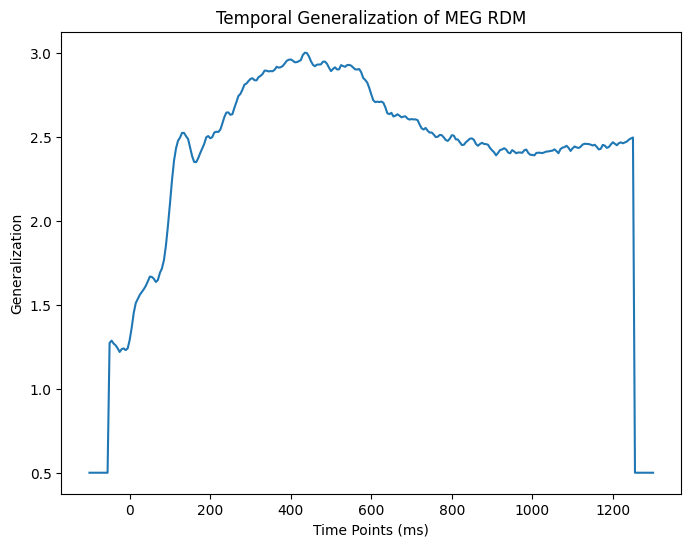

In [5]:
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

def compute_dynamic_sigma(rdm, sigma_max=5, sigma_min=0.2):
    # input rdm shape should be [n_time_points, n_stimuli, n_stimuli]
    def flatten_rdm(rdm):
        # Get the upper triangle indices, excluding the diagonal
        triu_indices = np.triu_indices(rdm.shape[-1], k=1)
        return rdm[..., triu_indices[0], triu_indices[1]]
    
    def compute_time_rsm(rdm):
        # Flatten the participant-by-participant RDM for each time point
        rdm_flat = flatten_rdm(rdm) # shaped (n_time_points, n_flattened_rdm_len)
        time_rsm = 1 - squareform(pdist(rdm_flat, metric='correlation'))
        return time_rsm
    
    def mean_diag_window(time_rsm, window_size=3):
        n = time_rsm.shape[0]
        time_generalization = np.zeros(n)
        
        for i in range(n):
            # Define the window around the diagonal, making sure it stays within matrix bounds
            start = max(0, i - window_size)
            end = min(n, i + window_size + 1)  # end is non-inclusive

            # Exclude the diagonal itself from the window values
            window_values = np.concatenate([time_rsm[i, start:i], time_rsm[i, i+1:end]])
            
            # If there are no values (e.g., in small matrices), handle that case
            if len(window_values) == window_size*2:
                time_generalization[i] = np.mean(window_values)
            else:
                time_generalization[i] = 0  # or any other fallback value
        
        return time_generalization

    
    def scale_for_sigma(x, sigma_max=3, sigma_min=0.2):
        y = (x - np.min(x)) / (np.max(x) - np.min(x))
        sigma = sigma_min + y * (sigma_max - sigma_min)
        return sigma
    
    time_rsm = compute_time_rsm(rdm)
    time_generalization = mean_diag_window(time_rsm, window_size=10)
    sigma_list = scale_for_sigma(time_generalization, sigma_max=sigma_max, sigma_min=sigma_min)
    return sigma_list


dynamic_sigma = compute_dynamic_sigma(mean_rdm, sigma_max=3, sigma_min=0.5)
plt.figure(figsize=(8, 6))
plt.plot(list(range(-100, 1301, 5)), sigma)
plt.xlabel('Time Points (ms)')
plt.ylabel('Generalization')
plt.title('Temporal Generalization of MEG RDM')
plt.show()